Dependencias a instalar e implementación de LangSmith para traquear la aplicación

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community

import os

os.environ["LANGCHAIN_TRACING_V2"]
os.environ["LANGCHAIN_API_KEY"]

from dotenv import load_dotenv # type: ignore
load_dotenv()


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


True

Carga del LLM, del modelo de embedding y de la base de datos vectorial ElasticSearch

In [ ]:
%pip install -qU langchain-openai
%pip install -qU langchain-openai
%pip install -qU langchain-elasticsearch

import os

os.environ["OPENAI_API_KEY"]

from langchain_openai import ChatOpenAI # type: ignore
from langchain_openai import OpenAIEmbeddings # type: ignore
from langchain_elasticsearch import ElasticsearchStore # type: ignore


llm = ChatOpenAI(model="gpt-4o-mini")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

elastic_vector_search = ElasticsearchStore(
    es_url="http://localhost:9200",
    index_name="langchain_index",
    embedding=embeddings,
    es_user=os.environ["ES_LOCAL_USERNAME"],
    es_password=os.environ["ES_LOCAL_PASSWORD"],
)


Ahora cargamos el contenido del cual se va a enriquecer la respuesta. Será un blog publicado en internet:
https://lilianweng.github.io/posts/2023-06-23-agent/

In [14]:
%pip install beautifulsoup4
import bs4 # type: ignore
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


USER_AGENT environment variable not set, consider setting it to identify your requests.


Note: you may need to restart the kernel to use updated packages.
Total characters: 43131


In [15]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


Como el documento cargado tiene +40k caracteres, es demasiado grande para darlo como contexto al LLM, por lo tanto, vamos a partirlo en chunks 

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter # type: ignore

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


Ahora necesitamos indexar y guardar los 66 chunks en elastic search para poder buscarlos posteriormente

In [17]:
document_ids = elastic_vector_search.add_documents(documents=all_splits)

print(document_ids[:3])

['e1290bee-1cda-4af8-82a0-baa2a6dce1f8', '35e06afc-b9f8-4805-8f2c-11d552b9122f', 'd7edca4b-e25b-4661-9deb-b25c2b73bdd1']


Ahora vamos a crear la lógica del RAG

In [ ]:
from langchain import hub # type: ignore

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Ahora usamos langGraph para crear los nodos de la lógica del agente

In [20]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = elastic_vector_search.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Ahora compilamos la aplicación en un objeto simple de graph

In [21]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

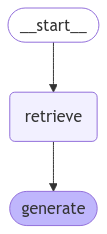

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Pongámosla a prueba ahora:

In [25]:
result = graph.invoke({"question": "What is Task Decomposition? Reply in Spanish"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 17804}, page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" field denotes the id of the previous task which generates a new resource that the current task relies on. A special tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From this chat history, you can find the path of the user-mentioned resources for your task planning.'), Document